Instalacion de dependencias

In [1]:
pip install pandas matplotlib seaborn scikit-learn openpyxl graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [25]:
file = 'Pruebas experimentales del rotavapor RCL.xlsx'
sheet = 'Datos'

try:
    df = pd.read_excel(file, sheet_name=sheet)
except FileNotFoundError:
    print(f"Error: The file '{file}' was not found.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    exit()

tabla = df.iloc[12:, 2:]
tabla.columns = df.iloc[11, 2:]
tabla.reset_index(drop=True, inplace=True)

# Tasa de evaporación = 6446 - 0,292 X1 - 52,58 X2 - 0,206 X3 + 0,34 X4 - 817 X5 + 674 X6 - 416 X7
tabla['Tasa de evaporación'] = (
    6446 -
    0.292 * tabla['X1'] -
    52.58 * tabla['X2'] -
    0.206 * tabla['X3'] +
    0.34 * tabla['X4'] -
    817 * tabla['X5'] +
    674 * tabla['X6'] -
    416 * tabla['X7']
)

print("Column names:", tabla.columns.tolist())
print(tabla)

Column names: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Masa Agua', 'Tasa de evaporación']
11   X1 X2   X3 X4    X5     X6    X7 Masa Agua Tasa de evaporación
0    80  3  200  8  4.26  0.052  6.54   189.814              60.408
1    60  2  150  8  4.33   0.04  6.54   102.816               63.85
2    60  1  200  8  4.33  0.052  6.54    78.214             114.218
3    70  2  200  8  4.28  0.052  6.54   177.115              99.568
4    70  1  250  8  4.28  0.076  6.54   158.054             158.024
..   .. ..  ... ..   ...    ...   ...       ...                 ...
107  85  2  275  8  4.25  0.082  6.54   216.333             124.468
108  65  2  275  8   4.3  0.082  6.54   170.492              89.458
109  75  1  175  8  4.27  0.046  6.54   186.669             159.964
110  65  3  225  8   4.3  0.064  6.54   175.175              35.046
111  65  2  225  6   4.3  0.064  6.56   177.439              78.626

[112 rows x 9 columns]


In [46]:
features = ["X1", "X2", "X3", "X4", "X5", "X6", "X7"]
target = "Etiqueta"

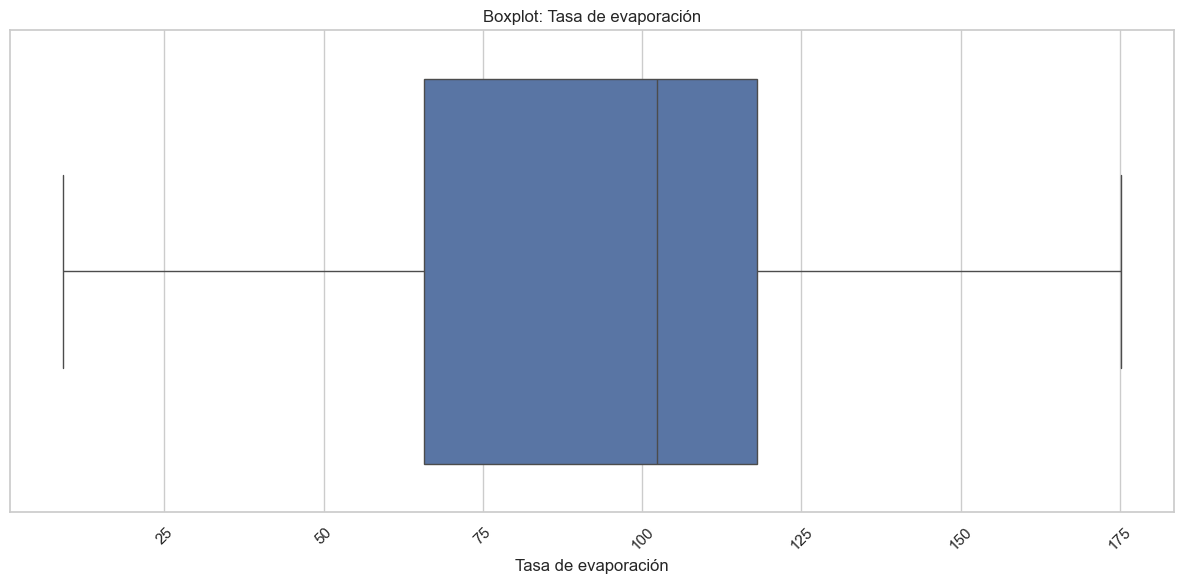

In [32]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=tabla["Tasa de evaporación"], orient='h')
plt.title('Boxplot: Tasa de evaporación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# Sacar la mediana de la tasa de evaporación
mediana = tabla["Tasa de evaporación"].median()
print(f"Mediana de la tasa de evaporación: {mediana}")

# Calcular la desviación estándar de la tasa de evaporación
desv = tabla["Tasa de evaporación"].std()    
print(f"Desviación estándar de la tasa de evaporación: {desv}")

Mediana de la tasa de evaporación: 102.27700000000073
Desviación estándar de la tasa de evaporación: 38.26168156915431


In [40]:
def etiqueta(valor):
    if valor < mediana - desv:
        return "Bajo"
    elif valor > mediana + desv:
        return "Alto"
    else:
        return "Medio"

# Aplicar a tu columna
tabla["Etiqueta"] = tabla["Tasa de evaporación"].apply(etiqueta)
# Mostrar la tabla con las etiquetas
print(tabla[["Tasa de evaporación", "Etiqueta"]])

11  Tasa de evaporación Etiqueta
0                60.408     Bajo
1                 63.85     Bajo
2               114.218    Medio
3                99.568    Medio
4               158.024     Alto
..                  ...      ...
107             124.468    Medio
108              89.458    Medio
109             159.964     Alto
110              35.046     Bajo
111              78.626    Medio

[112 rows x 2 columns]


# Arbol de decision

In [55]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

def decisionTreeF(data):
    X = data[features]
    y = data[target]

    decisionTree = DecisionTreeClassifier(random_state=42)
    decisionTree.fit(X, y)

    # Metrica de AUC-ROC (para multiclase usamos 'ovr' - one vs rest)
    auc_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='roc_auc_ovr')
    print("AUC-ROC en validación cruzada:", auc_scores)
    print("Promedio AUC-ROC:", np.mean(auc_scores))

    # Metrica de f1-score (promedio macro para multiclase)
    f1_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='f1_macro')
    print("f1-score en validación cruzada:", f1_scores)
    print("Promedio f1-score:", np.mean(f1_scores))

    # Metrica de precisión (promedio macro para multiclase)
    precision_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='precision_macro')
    print("Precisión en validación cruzada:", precision_scores)
    print("Promedio Precisión:", np.mean(precision_scores))

    # Metrica de accuracy
    accuracy_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='accuracy')
    print("Accuracy en validación cruzada:", accuracy_scores)
    print("Promedio Accuracy:", np.mean(accuracy_scores))

    return decisionTree



In [56]:
decisionTreeF(tabla)

AUC-ROC en validación cruzada: [1. 1. 1. 1. 1.]
Promedio AUC-ROC: 1.0
f1-score en validación cruzada: [1. 1. 1. 1. 1.]
Promedio f1-score: 1.0
Precisión en validación cruzada: [1. 1. 1. 1. 1.]
Promedio Precisión: 1.0
Accuracy en validación cruzada: [1. 1. 1. 1. 1.]
Promedio Accuracy: 1.0


DecisionTreeClassifier(random_state=42)

In [57]:
import graphviz
from sklearn.tree import export_graphviz

def dibujar_arbol(data, name, deep):
    X = data[features]
    y = data[target]

    decisionTree = DecisionTreeClassifier(random_state=42, max_depth=deep)
    decisionTree.fit(X, y)

    # Metrica de AUC-ROC (para multiclase)
    auc_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='roc_auc_ovr')
    print("AUC-ROC en validación cruzada:", auc_scores)
    print("Promedio AUC-ROC:", np.mean(auc_scores))

    # Metrica de f1-score (promedio macro)
    f1_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='f1_macro')
    print("f1-score en validación cruzada:", f1_scores)
    print("Promedio f1-score:", np.mean(f1_scores))

    # Metrica de accuracy
    accuracy_scores = cross_val_score(decisionTree, X, y, cv=5, scoring='accuracy')
    print("Accuracy en validación cruzada:", accuracy_scores)
    print("Promedio Accuracy:", np.mean(accuracy_scores))

    # Obtener las clases únicas para el export_graphviz
    clases_unicas = sorted(y.unique())
    export_graphviz(decisionTree, out_file=f"{name}_tree.dot", 
                   feature_names=features, 
                   class_names=clases_unicas, 
                   filled=True)

In [61]:
dibujar_arbol(tabla, "DecisionTree", 3)

AUC-ROC en validación cruzada: [0.99416792 0.99416792 1.         1.         1.        ]
Promedio AUC-ROC: 0.9976671694318753
f1-score en validación cruzada: [0.96102564 0.96102564 1.         1.         1.        ]
Promedio f1-score: 0.9844102564102565
Accuracy en validación cruzada: [0.95652174 0.95652174 1.         1.         1.        ]
Promedio Accuracy: 0.9826086956521738


# Random Forest

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def randomForest(data):
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Para clasificación multiclase, usamos roc_auc con multi_class='ovr'
    try:
        auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
        print("AUC-ROC (One vs Rest):", auc)
    except Exception as e:
        print(f"No se pudo calcular AUC-ROC: {e}")

    # Evaluar importancia de las variables
    importances = rf.feature_importances_
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    print("\nImportancia de Variables:")
    print(feature_importance)

    # Graficar importancia de las variables
    plt.figure(figsize=(8,6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importancia')
    plt.title('Importancia de Variables en el Modelo Random Forest')
    plt.gca().invert_yaxis()
    plt.show()
    
    return rf

Matriz de Confusión:
[[ 6  0  0]
 [ 0  7  2]
 [ 0  0 19]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00         6
        Bajo       1.00      0.78      0.88         9
       Medio       0.90      1.00      0.95        19

    accuracy                           0.94        34
   macro avg       0.97      0.93      0.94        34
weighted avg       0.95      0.94      0.94        34

AUC-ROC (One vs Rest): 1.0

Importancia de Variables:
  Feature  Importance
1      X2    0.584790
0      X1    0.115579
4      X5    0.094900
2      X3    0.074290
5      X6    0.063859
6      X7    0.040219
3      X4    0.026364


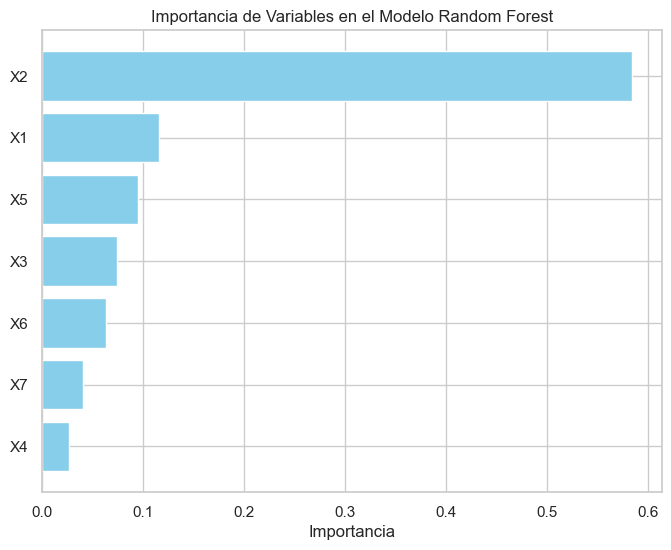

RandomForestClassifier(class_weight='balanced', random_state=42)

In [60]:
randomForest(tabla)